# Sampling from Truncated Distributions [6] 

This is the last post in this series and I will simply use it to showcase its use for a more complex example with 17 parameters (instead of 2). The example is inspired by the trend filtering method as explained in [1-2]. The example below is also related to the shape constrained spline models I have been working with [3-5].

### Multidimensional example

The next graph shows 17 noisy measurements ($y$) as a function of time ($t$):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
from scipy.sparse import spdiags
import sys
import pandas as pd
from pandas.plotting import scatter_matrix

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))
from truncsample.tmvn import truncmvn

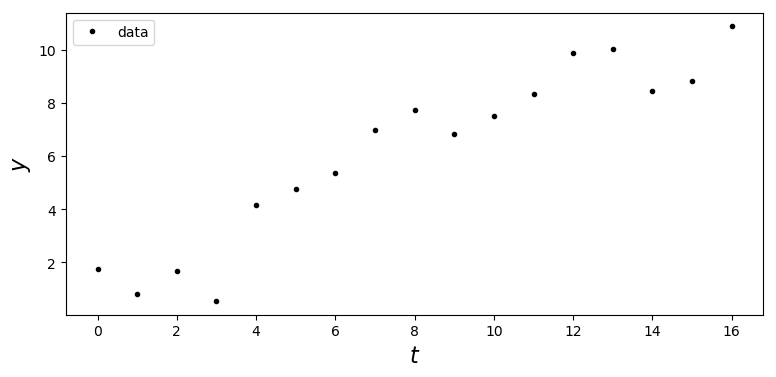

In [2]:
t_ = np.linspace (0,16,17)
y_ = 11*np.tanh(t_/10)
ytil_ = y_ + norm.rvs(loc=0, scale=1, size=len(y_), random_state=11)

fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
h1, = plt.plot(t_,ytil_,'k.',label='data');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
plt.legend(handles=[h1]);

The following figure shows the piece-wise linear trend line fitted to this data series. This is also known as a linear spline function. The model is conceptually simple of course but is complex in the sense that there are as many parameters as there are measurements. The same figure also shows an alternative trend line where the point-wise second derivative is constrained to be negative. This causes the fitted curve to have a concave shape. This constrained trend line is the least squares optimal solution satisfying this shape constraint. Assuming Gaussian and independent measurement errors with equal variance (homoskedasticity), this is also the maximum-likelihood solution satisfying the shape constraint.

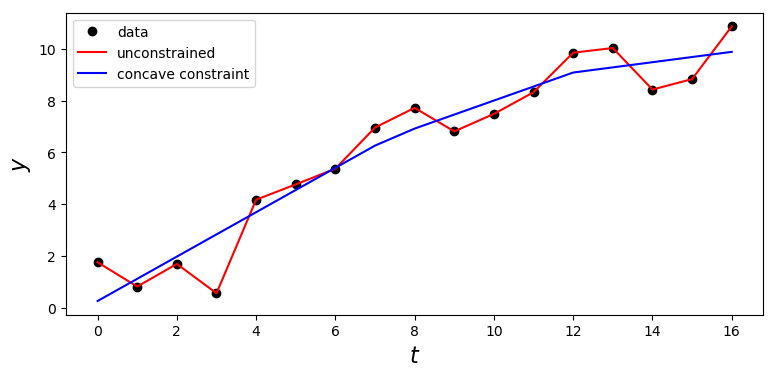

In [3]:
M= len(ytil_)

beta0 = ytil_
beta0_cov = np.eye(M)

data = np.array([-np.ones(M), +2*np.ones(M), -np.ones(M)])
diags = np.array([0, 1, 2])
F=spdiags(data, diags, M-2, M).toarray()
g = np.zeros(M-2)
g_init = np.ones(M-2)*0.05


beta =   cvx.Variable (M)
dev  =   cvx.Variable (M)
constraints  =   [  F*beta>=g ]
prob         =   cvx.Problem (cvx.Minimize (cvx.pnorm (beta-ytil_, p=2)) , constraints)
prob.solve ()
betahat        =   beta.value

fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
h1, = plt.plot(t_,ytil_,'ko',label='data');
h2, = plt.plot(t_,beta0,'r-',label='unconstrained');
h3, = plt.plot(t_,betahat,'b-',label='concave constraint');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
plt.legend(handles=[h1,h2,h3]);

### Results with Hamiltonian Monte Carlo sampler

I played around with the samplers and found out that the Hamiltonian Monte Carlo sampler produces parameter samples which are as a good as uncorrelated in a fairly efficient manner. The next figure shows the parameter values as a function of the sample index for 5 out of the 17 parameters. Visually speaking, one cannot recognize any significant autocorrelation.

In [4]:
K = 10000
burnin =1000
cov = True
TMVN = truncmvn(beta0, beta0_cov, F, g, cov)

beta =   cvx.Variable (M)
dev  =   cvx.Variable (M)
constraints  =   [  F*beta>=g_init ]
prob         =   cvx.Problem (cvx.Minimize (cvx.pnorm (beta-ytil_, p=2)) , constraints)
prob.solve ()
betainit        =   beta.value

beta_samples,bounce = TMVN.sample(K+burnin,betainit,sampler="hmc")

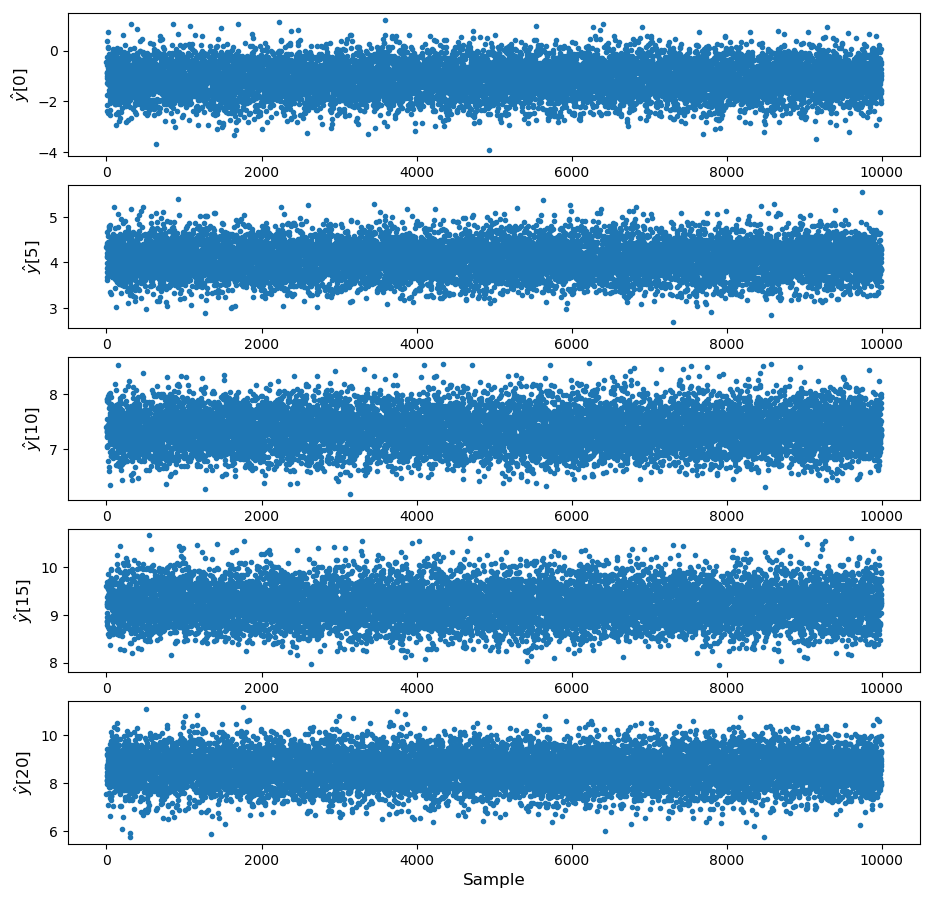

In [5]:
np.shape(beta_samples)

fig     =    plt.figure(figsize=(11,11),dpi=100);
fig.add_subplot(511);
ax = fig.gca()
plt.plot(beta_samples[0,burnin:],'.')
ax.set_ylabel('$\hat{y}[0]$', fontsize=12)
fig.add_subplot(512);
ax = fig.gca()
plt.plot(beta_samples[4,burnin:],'.')
ax.set_ylabel('$\hat{y}[5]$', fontsize=12)
fig.add_subplot(513);
ax = fig.gca()
plt.plot(beta_samples[8,burnin:],'.')
ax.set_ylabel('$\hat{y}[10]$', fontsize=12)
fig.add_subplot(514);
ax = fig.gca()
plt.plot(beta_samples[12,burnin:],'.')
ax.set_ylabel('$\hat{y}[15]$', fontsize=12)
fig.add_subplot(515);
ax = fig.gca()
plt.plot(beta_samples[16,burnin:],'.')
ax.set_ylabel('$\hat{y}[20]$', fontsize=12)
ax.set_xlabel('Sample', fontsize=12);

The next figure shows all sampled parameter values in a single plot. The diagonal panels in this plot are the estimated marginal distributions for the parameters. These appear unimodal but exhibit some visible asymmetry (skewness) for some parameters. The off-diagonal panels show the scatter plots of the parameter values for each pair of the parameters. Most of these panels show an even and spherical distribution. The panels close to the diagonal panels indicate strong correlations however. This means that the application of the concave shape constraints induces a strong correlation between parameters describing neighbouring measurements.

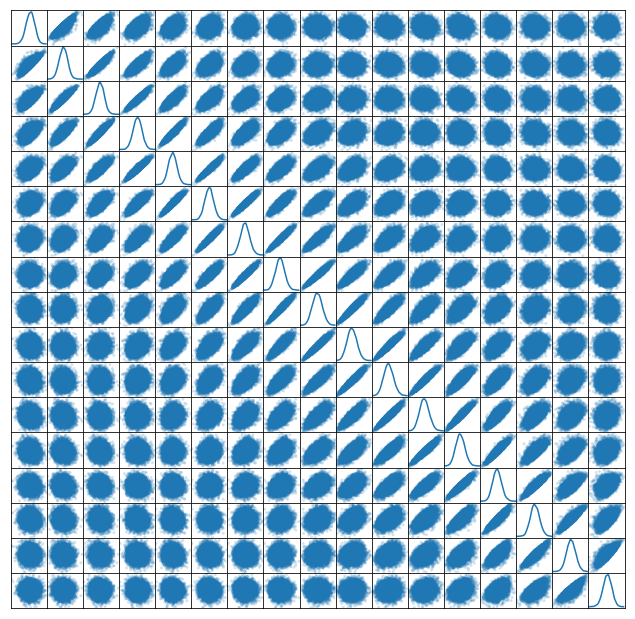

In [6]:
df = pd.DataFrame(beta_samples.T)
sm = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(11, 11), diagonal='kde');
for subaxis in sm:
    for ax in subaxis:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")

The next figure shows the median curve and the 5% and 95% quantiles of the trend line distribution. One can see that both the median profile and the quantile profiles adhere to the imposed concave shape constraint.

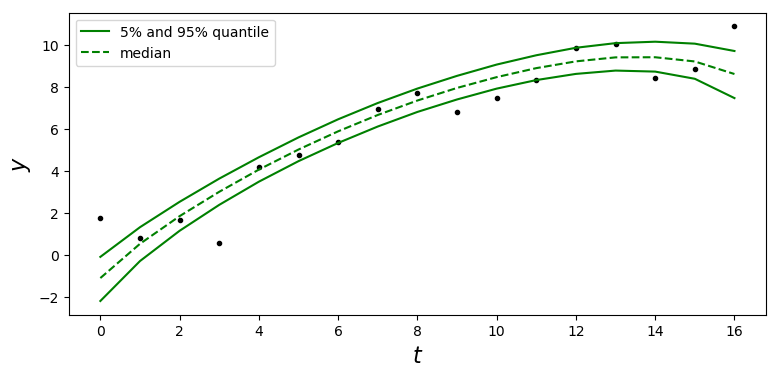

In [7]:
y_samples = beta_samples[:,burnin:]
ybar_ = np.mean(y_samples,axis=1)

fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
plt.plot(t_,ytil_,'k.');
y_uncbnd = np.quantile(y_samples, (.05,.50,.95), axis=1) 
h1, = plt.plot(t_,y_uncbnd[0,:],'g-',label='5% and 95% quantile');
h2, = plt.plot(t_,y_uncbnd[1,:],'g--',label='median');
h3, = plt.plot(t_,y_uncbnd[2,:],'g-');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16);
plt.legend(handles=[h1,h2]);
plt.show()

### Take home message and closing the series

In summary, this series of posts: 

* Describe what I have learned about sampling from truncated multivariate normal distributions

* Included some results with four samplers which are implemented for this purpose

* Demonstrated the sensitivity of some samplers to rotation of the coordinate system and mean shift.

From this, I took the following conclusions:

* There is not a single sampler which will do well for all problems. This is not exactly surprising but also a bit of a bummer.

* The rejection sampler and the Hamiltonian Monte Carlo (HMC) sampler deliver samples without (significant) autocorrelation in many cases but this is not always guaranteed.

* In contrast to my expectations, the HMC sampling can be rather inefficient computationally. While a more efficient implementation may be possible, my colleague Juan Pablo Carbajal explained to me that the HMC should only be expected to work really well if the distribution is sufficiently similar to a multivariate normal distribution without truncation.

### References

[1] Tibshirani, R. J. (2014). Adaptive piecewise polynomial estimation via trend filtering. The Annals of Statistics, 42(1), 285-323. [[preprint]](https://arxiv.org/abs/1304.2986) [[publisher]](https://projecteuclid.org/euclid.aos/1395234979)

[2] Tibshirani, R., Wainwright, M., & Hastie, T. (2015). Statistical learning with sparsity: The lasso and generalizations. Chapman and Hall/CRC. [[free download]](https://web.stanford.edu/~hastie/StatLearnSparsity/) [[publisher]](https://www.crcpress.com/Statistical-Learning-with-Sparsity-The-Lasso-and-Generalizations/Hastie-Tibshirani-Wainwright/p/book/9781498712163)

[3] Villez, K, Habermacher, J (2016). Shape anomaly detection for process monitoring of a sequencing batch reactor. Comp Chem Eng, 91, 365-379. [[preprint]](https://www.eawag.ch/fileadmin/Domain1/Abteilungen/eng/projekte/spike/Publications/KV_A029.pdf) [[publisher]](https://www.sciencedirect.com/science/article/pii/S0098135416301089)

[4] Masic, A, Srinivasan, S, Billeter, J, Bonvin, D, Villez, K (2017). Shape constrained splines as transparent black-box models for bioprocess modeling. Comp Chem Eng, 99, 96-105. [[preprint]](https://www.eawag.ch/fileadmin/Domain1/Abteilungen/eng/projekte/spike/Publications/KV_A032.pdf) [[publisher]](https://www.sciencedirect.com/science/article/pii/S0098135416304227)

[5] Thürlimann, C M, Villez, K (2017). Input estimation as a qualitative trend analysis problem. Comp Chem Eng, 107, 333-342. [[preprint]](https://www.eawag.ch/fileadmin/Domain1/Abteilungen/eng/projekte/spike/Publications/KV_A035.pdf) [[publisher]](https://www.sciencedirect.com/science/article/pii/S0098135417301680)